# Выгрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from bs4 import BeautifulSoup

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor # Модель 2

from sklearn.ensemble import RandomForestRegressor # Модель 3

from sklearn.ensemble import ExtraTreesRegressor # Модель 4

from xgboost import XGBRegressor # Модель 5
from sklearn.ensemble import StackingRegressor # Модель 5
from sklearn.linear_model import LinearRegression # Модель 5

In [2]:
RANDOM_SEED = 42

# Датасеты

In [3]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv', low_memory = False)
train_parsed = pd.read_csv('train_df_full_part1.csv', low_memory = False)
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [4]:
test

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,NaN,Продается BMW 316i в отличном состоянии. Прода...,1.6 LTR,136 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,...,SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,3 или более,2 года и 1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
34682,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,NaN,Продаётся отличный автомобиль.,2.0 LTR,190 N12,NaN,дизель,...,SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
34683,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,NaN,Хорошее состояние,2.5 LTR,170 N12,NaN,бензин,...,SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,"{""id"":""6336008"",""name"":""xDrive20d Локальная сб...",Автомобиль в идеальном состоянии . Куплен новы...,2.0 LTR,184 N12,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,...,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


#### Проверяем наличие строк и столбцов

In [5]:
# Проверка количества столбцов и строк
print(f"Количество столбцов в train: {len(train.columns)}, количество строк: {len(train)}")
print(f"Количество столбцов в test: {len(test.columns)}, количество строк: {len(test)}")
print(f"Количество столбцов в sample: {len(sample.columns)}, количество строк: {len(sample)}")
print(f"Количество столбцов в train_parsed: {len(train_parsed.columns)}, количество строк: {len(train_parsed)}")

# Есть существенная в количестве столбцов между train,test,train_parsed
# С учетом наличия прайса в датасете sample (т.е. test - 33 столбца), у нас остаются немалые расхождения
# Проблема решается двумя способами:
# 1. Удалить лишние столбцы из train_parsed, которых нет в test
# 2. Удалить лишние столбцы из test, которых нет в train

Количество столбцов в train: 26, количество строк: 89378
Количество столбцов в test: 32, количество строк: 34686
Количество столбцов в sample: 2, количество строк: 34686
Количество столбцов в train_parsed: 36, количество строк: 130201


## Функции

In [6]:
# Для удобства будем использовать заготовленную функцию и по мере продвижения менять название столбцов
def rename_column(df, column, new_column):
    df.rename(columns = {column : new_column}, inplace = True)
    
    
# Проверим отличия в столбцах между train_parsed и test
# Тем самым сделаем заготовку, для будущего удаления столбцов из train_parsed
def check_df(df1, df2):
    print('Columns in df1, but not in df2: ', list(set(df1.columns).difference(df2.columns)))
    print(f'df1 : df2')
    print()
    for col1 in df1.columns:
        for col2 in df2.columns: 
            if col1 == col2 and df1[col1].dtype != df2[col2].dtype:
                print(col1, df1[col1].dtype,' | ',col2, df2[col2].dtype)

                
# Првоерка столбца на количество пустых строк и уникальные значения
def check_column(df, col):
    print(f'Пустых значений: {df[col].isna().sum()}')
    print(f'Кол-во строк в столбце: {len(df[col])}')
    print(f'Тип данных столбца: {df[col].dtype}')
    print()
    print(f'Уникальных значений: {df[col].unique()}')    
    

# Конвертируем найденные данные объема двигателя в тип данных float
def engineDisplacement_to_float(cell):
    re_find = re.findall('\d\.\d', str(cell))
    if re_find:
        return float(re_find[0])
    return None


# Заполнение столбца "Привод"/"driving_gear"
def fill_driving_gear(brand: str, model_name: str, df: pd.DataFrame):
    sliced_df = df[(df.brand == brand) & (df.model_name == model_name)]
    try:
        return sliced_df.driving_gear.values[0]
    except:
        return 'полный'
    
    
# Заполнение столбца "Руль"/"steering_wheel"
def fill_steering_wheel(brand: str, model: str, right_wheel_dict: dict):
    try:
        if model in right_wheel_dict[brand]:
            return 'right'
        else:
            return 'left'
    except:
        return 'left'


# Заполнение название модели
def fill_model_name(all_model_names: list, name: str):
    name = name.lower()
    if isinstance(name, str):
        if "RS Q8".lower() in name:
            return 'Q8'
        elif "QX55".lower() in name:
            return "QX55"
        try:
            value = name.split()
        except:
            return None
        if value[1] in all_model_names:
            return value[1]
        try:
            joined_value = "_".join([value[1], value[2]])
        except IndexError:
            return None
        if joined_value in all_model_names:
            return f"{value[1]}_{value[2]}"
        elif joined_value.replace('_', ' ') in all_model_names:
            return f"{value[1]} {value[2]}"
    return None


# Визуализация данных с помощью Boxplot
def show_boxplot(data: pd.DataFrame, column: str, target_column: str):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=target_column, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
    
# Метрика MAPE с использованием mean_absolute_percentage_error
# Версия с использованием MAPE из sklearn
def mape(y_true, y_pred):
    print(f'Mape: {(mean_absolute_percentage_error(y_true, y_pred)*100):0.2f}%')
    
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### Сравнение датасетов

In [7]:
print(check_df(train, test))
print(check_df(train_parsed, test))
print(check_df(train, train_parsed))

Columns in df1, but not in df2:  ['start_date', 'hidden', 'model', 'price', 'Комплектация']
df1 : df2

modelDate float64  |  modelDate int64
numberOfDoors float64  |  numberOfDoors int64
enginePower float64  |  enginePower object
Состояние float64  |  Состояние object
Владельцы float64  |  Владельцы object
Таможня bool  |  Таможня object
None
Columns in df1, but not in df2:  ['price', 'region', 'views', 'date_added']
df1 : df2

mileage float64  |  mileage int64
modelDate float64  |  modelDate int64
model_info float64  |  model_info object
numberOfDoors float64  |  numberOfDoors int64
parsing_unixtime float64  |  parsing_unixtime int64
productionDate float64  |  productionDate int64
sell_id float64  |  sell_id int64
vendor float64  |  vendor object
None
Columns in df1, but not in df2:  ['start_date', 'hidden', 'model', 'Комплектация']
df1 : df2

productionDate int64  |  productionDate float64
enginePower float64  |  enginePower object
mileage int64  |  mileage float64
Состояние float64 

### Сравнение столбцов

In [8]:
for df_columns in [train, train_parsed, test]:
    print(df_columns.columns.sort_values())

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'hidden', 'mileage', 'model', 'modelDate',
       'name', 'numberOfDoors', 'price', 'productionDate', 'start_date',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'Комплектация', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')
Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'date_added', 'description', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate',
       'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'price', 'priceCurrency', 'productionDate', 'region', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'views', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня'],
      dtype='object')
Index(['bodyType', 'brand', 'car_url', '

### bodyType

In [9]:
train['bodyType'] = train.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
train_parsed['bodyType'] = train_parsed.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
test['bodyType'] = test.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [10]:
check_column(train, 'bodyType')

Пустых значений: 1
Кол-во строк в столбце: 89378
Тип данных столбца: object

Уникальных значений: ['седан' 'универсал' 'хэтчбек' 'кабриолет' 'купе' 'лифтбек' 'внедорожник'
 'компактвэн' 'купе-хардтоп' 'родстер' 'минивэн' 'пикап' 'тарга'
 'микровэн' 'фастбек' nan 'седан-хардтоп' 'фургон' 'лимузин']


In [11]:
check_column(train_parsed, 'bodyType')

Пустых значений: 215
Кол-во строк в столбце: 130201
Тип данных столбца: object

Уникальных значений: ['лифтбек' 'внедорожник' 'компактвэн' 'хэтчбек' 'универсал' 'седан' nan
 'купе' 'кабриолет' 'родстер' 'минивэн' 'микровэн' 'пикап' 'купе-хардтоп'
 'фургон' 'лимузин' 'седан-хардтоп']


In [12]:
check_column(test, 'bodyType')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['лифтбек' 'внедорожник' 'хэтчбек' 'седан' 'компактвэн' 'универсал'
 'пикап' 'купе' 'кабриолет' 'минивэн' 'родстер' 'микровэн' 'купе-хардтоп'
 'фастбек' 'тарга' 'лимузин' 'седан-хардтоп' 'фургон']


In [13]:
train_parsed.dropna(subset = ['bodyType'], axis = 0, inplace = True)

### brand

In [14]:
# Проверим на наличие строк по бренду из двух датасетов. Ведь датасет test наша основная цель.
print(f'В train {len(train[train.brand.isin(test.brand.unique())])} строк из {len(train)} сходятся по бренду.')
print(f'Это {round((len(train[train.brand.isin(test.brand.unique())]) / len(train)) * 100, 2)}% изначального датасета.')
print()
print(f'В train_parsed {len(train_parsed[train_parsed.brand.isin(test.brand.unique())])} строк из {len(train_parsed)} сходятся по бренду.')
print(f'Это {round((len(train_parsed[train_parsed.brand.isin(test.brand.unique())]) / len(train_parsed)) * 100, 2)}% изначального датасета.')

В train 49309 строк из 89378 сходятся по бренду.
Это 55.17% изначального датасета.

В train_parsed 129986 строк из 129986 сходятся по бренду.
Это 100.0% изначального датасета.


In [15]:
# Используем только нужные нам строки.
train = train[train.brand.isin(test.brand.unique())]
train_parsed = train_parsed[train_parsed.brand.isin(test.brand.unique())]

In [16]:
check_column(train, 'brand')

Пустых значений: 0
Кол-во строк в столбце: 49309
Тип данных столбца: object

Уникальных значений: ['AUDI' 'BMW' 'HONDA' 'INFINITI' 'LEXUS' 'MITSUBISHI' 'NISSAN' 'SKODA'
 'TOYOTA' 'VOLKSWAGEN' 'VOLVO' 'MERCEDES']


In [17]:
check_column(train_parsed, 'brand')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [18]:
check_column(test, 'brand')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


### color

In [19]:
check_column(train, 'color')

Пустых значений: 0
Кол-во строк в столбце: 49309
Тип данных столбца: object

Уникальных значений: ['040001' 'EE1D19' '0000CC' 'CACECB' '007F00' 'FAFBFB' '97948F' '22A0F8'
 '660099' '200204' 'C49648' 'DEA522' '4A2197' 'FFD600' 'FF8649' 'FFC0CB']


In [20]:
check_column(train_parsed, 'color')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ['белый' 'синий' 'серый' 'чёрный' 'серебристый' 'бежевый' 'красный'
 'коричневый' 'оранжевый' 'пурпурный' 'жёлтый' 'зелёный' 'голубой'
 'фиолетовый' 'золотистый' 'розовый']


In [21]:
check_column(test, 'color')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']


In [22]:
train['color'].replace(to_replace={'040001' : 'чёрный', 'EE1D19': 'красный', '0000CC' : 'синий', 'CACECB': 'серебристый',
                                   '007F00' : 'зелёный', 'FAFBFB' : 'белый', '97948F' : 'серый', '22A0F8' : 'голубой', 
                                   '660099' : 'пурпурный', '200204' : 'коричневый', 'C49648' : 'бежевый', 
                                   'DEA522' : 'золотистый', '4A2197' : 'фиолетовый', 'FFD600' : 'жёлтый',
                                   'FF8649' : 'оранжевый', 'FFC0CB' : 'розовый'}, inplace = True)

### description

In [23]:
check_column(train, 'description')

Пустых значений: 1588
Кол-во строк в столбце: 49309
Тип данных столбца: object

Уникальных значений: [' Машина  в приличном состоянии ,не гнилая не ржавая .По менины этим  летом коренные  и шатунные вкладыши .Масло не ест .  Цвет черный .Год выпуска 1991.Двигатель 2.8.Привод полный кватро.Все стеклоподъемники .Кожаный салон  .   '
 'Машина в оригинале не гнилая все вопросы по телефону. Птс оригинал, двигатель 1.8 90 л/с, карбюратор родной двигатель масло не ест. '
 'ПТС Оригинал!\nПолный комплект ключей!\nПо результатам комплексной диагностики автомобиля серьезных замечаний не выявлено.\n\nКомплектация:\n•\tАнтиблокировочная система\n•\tАнтипробуксовочная система\n•\tСистема курсовой устойчивости\n•\tБлокировка замков задних дверей\n•\tСигнализация\n•\tИммобилайзер\n•\tЦентральный замок\n•\tУсилитель руля\n•\tАктивный усилитель руля\n•\tЭлектропривод зеркал\n•\tАудиосистема\n•\tАудиоподготовка\n•\tРозетка 12V\nБолее 200 автомобилей с пробегом в наличии!\n- выгода до 70 000 рублей за Тр

In [24]:
check_column(train_parsed, 'description')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ['Автомобиль приобретался у официального дилера Оригинальный ПТС Дополнительные опции Обогрев всех сидений Биксеноновая головная оптика Датчики дождя и света Двухзонный климат контроль Круиз контроль Передние и задние датчики парковки Дополнительное оборудование Сигнализация с автозапуском 007944 Кредит от 8 Первоначальный взнос от 0 Более 20 банков партнеров Ваш автомобиль может быть первоначальным взносом Оформление за 30 минут По двум документам Без справок и поручителей Без скрытых платежей и комиссий Возможна дистанционная подача заявки на кредит iobgogf 45095 '
 'Группа компаний Элан Моторс официальный дилер представляет на автомобильном рынке Санкт Петербурга и Северо Западного федерального округа бренды CHERY HAVAL LIFAN ZOTYE DFM JAC MOTORS УАЗ КРЕДИТ 7 9 годовых НИЖЕ ПОТРЕБИТЕЛЬСКОГО КРЕДИТА На данный автомобиль действует скидка при покупке в кредит В нашем автоцентре Вы можете 

In [25]:
check_column(test, 'description')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписатьс

In [26]:
# Удаляем блок, т.к. информации много и капаться в ней будет, возможно, не так выгодно.

train.drop('description', axis = 1, inplace = True)
train_parsed.drop('description', axis = 1, inplace = True)
test.drop('description', axis = 1, inplace = True)

### engineDisplacement

In [27]:
train['engineDisplacement'] = train.name.apply(
                                engineDisplacement_to_float)
train_parsed['engineDisplacement'] = train_parsed.engineDisplacement.apply(
                                lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x).apply(
                                lambda x: float(x.replace("LTR", "")) if isinstance(x, str) else x)
test['engineDisplacement'] = test.engineDisplacement.apply(
                                lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x).apply(
                                lambda x: float(x.replace("LTR", "")) if isinstance(x, str) else x)

In [28]:
# Отсутствующие значения в train.engineDisplacement - электроавтомобили. Заменяем значения на ноль, как в test. 
train.loc[(train['engineDisplacement'].isna()) & (train['fuelType'] == 'электро'), 'engineDisplacement'] = 0.0

In [29]:
check_column(train, 'engineDisplacement')

Пустых значений: 1
Кол-во строк в столбце: 49309
Тип данных столбца: float64

Уникальных значений: [2.8 1.8 2.3 2.  2.6 2.2 2.5 1.9 2.1 2.4 1.6 1.3 3.3 1.4 1.2 3.2 1.5 3.1
 3.  2.7 4.2 4.  3.9 6.3 6.  3.7 4.1 0.  3.6 5.9 5.2 2.9 5.  1.7 4.4 3.4
 3.5 4.8 5.4 6.6 0.7 4.9 4.6 nan 4.5 5.6 4.3 4.7 5.7 1.1 3.8 1.  6.2 5.5
 5.8 5.3]


In [30]:
check_column(train_parsed, 'engineDisplacement')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: float64

Уникальных значений: [1.8 1.6 1.4 1.2 2.  3.6 1.5 1.9 1.3 2.8 3.  3.1 2.7 4.  2.4 2.9 4.2 2.5
 3.2 4.1 3.7 2.3 2.2 2.6 0.  5.9 5.2 5.  2.1 6.  3.5 0.7 1.7 4.4 5.6 4.8
 6.6 4.6 4.9 3.4 5.4 3.8 1.  3.3 4.5 5.5 4.7 6.2 5.8 4.3 5.7 1.1]


In [31]:
check_column(test, 'engineDisplacement')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: float64

Уникальных значений: [1.2 1.6 1.8 2.  1.4 1.3 1.  3.6 1.5 1.9 2.8 1.1 2.5 4.2 3.  4.  5.9 2.7
 3.1 2.4 5.2 3.2 4.1 6.3 2.3 6.  2.2 3.7 2.9 5.  3.3 2.1 2.6 0.  3.5 1.7
 0.7 4.4 4.8 5.4 6.6 4.9 3.8 3.4 3.9 4.6 5.6 4.5 5.5 6.2 4.7 4.3 5.8 5.3
 5.7]


In [32]:
train.dropna(subset = ['engineDisplacement'], axis = 0, inplace = True)

### enginePower

In [33]:
train_parsed['enginePower'] = train_parsed['enginePower'].apply(
    lambda x: None if x == 'undefined N12' else float(str(x).replace(' N12', '')))

test['enginePower'] = test['enginePower'].apply(lambda x: float(x.split(' ')[0]))

In [34]:
check_column(train, 'enginePower')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: float64

Уникальных значений: [174.  90. 136. 101. 133. 150. 115. 137. 112. 230.  70.  88. 100.  75.
 165. 182. 170. 113.  80.  54.  60.  71. 122. 125.  61. 102. 190. 180.
 160. 105. 140. 110. 250. 200. 130. 120. 225. 163. 211. 249. 255. 143.
 220. 239. 265. 116. 193. 177. 240. 245. 204. 340. 300. 233. 310. 218.
 210. 290. 333. 335. 224. 350. 155. 254. 338. 435. 372. 460. 275. 500.
 260. 450. 420. 280. 326. 285. 408. 271. 272. 270. 238. 252. 610. 525.
 430. 367. 605. 560. 580. 256. 354. 571. 360. 520. 400. 156. 306. 320.
 184. 129. 258. 231. 118. 192. 286.  98. 234. 171.  46.  51. 407. 530.
 313. 235. 381. 462. 197. 109. 609. 544. 445. 329. 188. 370. 410. 431.
 343. 507. 600. 625. 510. 355. 269. 264. 347. 555. 575. 321. 201. 281.
 131. 154. 152. 147. 135.  53. 215.  44. 142.  95.  92. 114.  94. 103.
 126.  91.  85. 166. 128. 186. 162. 145. 194.  86. 124.  83.  78. 295.
 205.  50.  65.  64.  58. 284. 257. 243. 185. 247

In [35]:
check_column(train_parsed, 'enginePower')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: float64

Уникальных значений: [180. 110.  90. 150. 105. 125. 152. 102.  70.  80. 122. 140.  86.  75.
  68. 115. 260. 280.  64. 220. 143. 100.  58. 200.  60. 160. 170. 120.
  54. 190.  69.  79. 101. 193. 184.  53. 249. 250. 255. 211. 340. 245.
 225. 272. 333. 290. 204. 300. 460. 239. 310. 520. 165. 422. 130. 450.
 372. 350. 230. 163. 233. 177. 238. 265. 435. 344. 133. 136. 270. 252.
 600. 605. 367. 420. 354. 408.  88.  71. 500. 271. 400. 218. 210. 335.
 571. 560. 174. 112. 144. 137. 646. 113. 610. 580. 525. 550. 231. 380.
 320. 313. 360. 256.  93. 166. 145. 186.  83. 118. 201. 147. 155. 156.
 142. 257.  52. 205. 132. 182. 154.  78.  98. 158. 128. 243. 162. 192.
  91. 295. 103.  95. 275. 194. 116. 173. 281.  66. 135.  94. 188. 185.
 109. 131.  99.  85. 141. 212.  42. 124. 248. 240. 247.  50. 215.  46.
 175. 314.  76. 237. 197.  67.  44. 114.  82. 176. 148. 106.  92. 181.
 235. 286. 203. 254. 315. 304. 126. 117. 407.  8

In [36]:
check_column(test, 'enginePower')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: float64

Уникальных значений: [105. 110. 152. 200. 102. 150.  90. 180. 220. 122.  70. 140. 125.  54.
  86.  75.  64.  95. 260. 170.  80.  68. 160. 115. 280.  53.  60. 143.
  42. 101.  58. 193.  79.  30. 100.  50. 163. 225. 420. 211. 245. 560.
 500. 249. 450. 605. 250. 354. 120. 290. 230. 350. 204. 255. 340. 177.
 272. 372. 210. 130. 300. 190. 239. 435. 333. 271. 326. 238. 310. 233.
 252. 133. 460. 520. 400. 525. 367. 265. 550. 580.  88. 165. 430. 335.
 174. 224. 136. 256. 338. 112. 218. 360.  93. 182. 113. 240. 270. 137.
 155.  61. 254. 116.  71. 285. 408. 166. 156. 257. 201. 162. 194. 142.
 154. 147. 281. 243. 118. 128.  91.  83. 205. 247. 188. 295. 275.  78.
 109.  94. 185. 258. 145. 132. 135.  52.  66. 124.  98. 215. 158.  99.
 103. 131. 126. 235. 181. 315. 203. 231.  82. 304. 175. 320. 213. 144.
 146. 151. 111. 286. 306. 107. 184. 313. 264. 575. 407. 192. 129. 555.
 625. 329. 370. 381. 269. 600. 510. 544. 462. 355

In [37]:
train_parsed.dropna(subset = ['enginePower'], axis = 0, inplace = True)

### fuelType

In [38]:
check_column(train, 'fuelType')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: object

Уникальных значений: ['бензин' 'дизель' 'электро' 'гибрид' 'газ']


In [39]:
check_column(train_parsed, 'fuelType')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ['бензин' 'дизель' 'электро' 'гибрид' 'газ']


In [40]:
check_column(test, 'fuelType')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['бензин' 'дизель' 'гибрид' 'электро' 'газ']


### hidden

In [41]:
check_column(train, 'hidden')

Пустых значений: 49308
Кол-во строк в столбце: 49308
Тип данных столбца: float64

Уникальных значений: [nan]


In [42]:
train.drop('hidden', axis = 1, inplace = True)

### mileage

In [43]:
check_column(train, 'mileage')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: int64

Уникальных значений: [350000 173424 230000 ... 526000  58726    520]


In [44]:
check_column(train_parsed, 'mileage')

Пустых значений: 26954
Кол-во строк в столбце: 129986
Тип данных столбца: float64

Уникальных значений: [162026.  19210.     nan ...  89865. 112968. 162411.]


In [45]:
check_column(test, 'mileage')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: int64

Уникальных значений: [ 74000  60563  88000 ... 121276 212678 157965]


In [46]:
train_parsed['mileage'] = train_parsed.mileage.fillna(0.0).astype(np.int64)

In [47]:
# Меняем значения в датасете test в столбце mileage. Т.к. 1 - не может быть.
# Далее mileage может нам помочь в определении новое авто или с пробегом. (меняем цену подстать данным)
# test['mileage'] = test.mileage.apply(lambda x: 0 if x == 1 else x).sort_values()

### model

In [48]:
train.rename(columns = {'model' : 'model_name'}, inplace = True)

In [49]:
# Забираем нужную информацию из test.model_info - Полное название модели: Сокращенное название
test['model_full'] = test.model_info.apply(lambda x: re.findall(r',"name":"(.+?)","ru_name',x)[0])
test['model_short'] = test.model_info.apply(lambda x: re.findall(r'code"'":"'"(.+?)"'","'"name',x)[0])
model_info_dict = {b:v for b,v in test.groupby(['model_full', 'model_short']).name.count().index}

# Использование словаря для определения модели в train_parsed.model_name
train_parsed['model_short'] = train_parsed.model_name.map(model_info_dict)

# Удалям лишние столбцы: предыдущий model_name из train_parsed
train_parsed.drop(['model_name'], axis = 1, inplace = True)

# Удалям лишние столбцы: model_full, model_short из test
test.drop(['model_full', 'model_short'], axis = 1, inplace = True)

# Переименнуем новый столбец model_short в model_name
train_parsed.rename(columns={'model_short': 'model_name'}, inplace=True)

# Удалям лишние столбцы: model_info из train_parsed
train_parsed.drop(['model_info'], axis = 1, inplace = True)

In [50]:
check_column(train, 'model_name')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: object

Уникальных значений: ['100' '200' '80' '90' '920' 'A1' 'A2' 'A3' 'A4' 'A4_ALLROAD' 'A5' 'A6'
 'ALLROAD' 'A7' 'A8' 'COUPE' 'E_TRON' 'Q3' 'Q3_SPORTBACK' 'Q5' 'Q7' 'Q8'
 'R8' 'RS3' 'RS4' 'RS5' 'RS6' 'RS7' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'SQ5'
 'TT' 'TT_RS' 'TTS' 'V8' '02' '1ER' 'M1' '2ER' '2ACTIVETOURER'
 '2GRANDTOURER' '3ER' '321' '326' '340' '4' '5ER' '6ER' '7ER' '8ER' 'E3'
 'I3' 'I8' 'M2' 'M3' 'M4' 'M5' 'M6' 'M8' 'X1' 'X2' 'X3' 'X3_M' 'X4' 'X5'
 'X5_M' 'X6' 'X6_M' 'X7' 'Z1' 'Z3' 'Z3M' 'Z4' 'ACCORD' 'ACTY' 'AIRWAVE'
 'ASCOT' 'AVANCIER' 'CITY' 'CIVIC' 'CIVIC_FERIO' 'CIVIC_TYPE_R' 'CONCERTO'
 'CR_V' 'CR_X' 'CR_Z' 'CROSSROAD' 'CROSSTOUR' 'DOMANI' 'EDIX' 'ELEMENT'
 'ELYSION' 'FIT' 'FR_V' 'FREED' 'HR_V' 'INSIGHT' 'INSPIRE' 'INTEGRA'
 'JAZZ' 'LEGEND' 'LIFE' 'LOGO' 'MOBILIO' 'MOBILIO_SPIKE' 'N_BOX' 'N_ONE'
 'N_WGN' 'ODYSSEY' 'ODYSSEY_NA' 'ORTHIA' 'PARTNER' 'PASSPORT' 'PILOT'
 'PRELUDE' 'RAFAGA' 'RIDGELINE' 'S_MX' 'S2000

In [51]:
check_column(train_parsed, 'model_name')

Пустых значений: 27264
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ['OCTAVIA' 'RAPID' nan 'KAROQ' 'YETI' 'SUPERB' 'KODIAQ' 'ROOMSTER' 'FABIA'
 'FELICIA' 'OCTAVIA_RS' 'FABIA_RS' 'FAVORIT' '120' 'A7' 'A8' 'A6' 'Q3'
 'Q5' 'A5' 'Q7' 'A4' 'TT' 'A3' 'S8' 'TTS' 'RS5' '80' 'Q8' 'RSQ3' 'ALLROAD'
 'A1' 'A4_ALLROAD' 'S4' '100' '200' 'A2' 'RS6' 'RS3' 'SQ5' 'TT_RS' 'RS7'
 'S6' 'S5' 'E_TRON' 'R8' 'V8' '90' 'RS4' 'S7' 'COUPE' 'S3' 'CR_V' 'CIVIC'
 'ORTHIA' 'JAZZ' 'FIT' 'PILOT' 'FREED' 'ODYSSEY' 'ACCORD' 'STREAM' 'ZEST'
 'HR_V' 'N_WGN' 'STEPWAGON' 'LEGEND' 'VEZEL' 'INTEGRA' 'SHUTTLE'
 'CIVIC_TYPE_R' 'INSIGHT' 'SABER' 'PRELUDE' 'ELEMENT' 'AIRWAVE' 'PARTNER'
 'CROSSTOUR' 'CIVIC_FERIO' 'TORNEO' 'N_BOX' 'LOGO' 'MOBILIO'
 'MOBILIO_SPIKE' 'ODYSSEY_NA' 'CROSSROAD' 'FR_V' 'DOMANI' 'ASCOT'
 'INSPIRE' 'CITY' 'ELYSION' 'AVANCIER' 'S2000' 'CR_Z' 'RIDGELINE' 'VIGOR'
 'CR_X' 'Z' 'ACTY' 'CONCERTO' 'RAFAGA' 'XC70' 'V40_CC' 'S60' 'S80' 'S40'
 'XC90' 'XC60' 'S90' 'XC40' 'C30' 'V90_CRO

In [52]:
check_column(test, 'model_name')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR' 'Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6'
 'ALLROAD' 'TT' 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD'
 'Q8' '100' 'SQ5' 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS'
 '920' 'S3' '200' 'V8' 'E_TRON' 'CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY'
 'STREAM' 'CROSSTOUR' 'ELYSION' 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V'
 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ' 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z'
 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'PRELUDE'
 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA' 'INSPIRE' 'VEZEL' 'N_WGN'
 'ASCOT' 'LOGO' 'ACTY' 'CONCERTO' 'AVANCIER' 'SABER' 'MOBILIO' 'CROSSROAD'
 'INSIGHT' 'TORNEO' 'AIRWAVE' 'DOMANI' 'RAFAGA' 'CITY' 'VIGOR' 'ORTHIA'
 'PARTNER' 'V60_CROSS_COUNTRY' 'XC40' 'XC60' 'C30' 'V50' 'XC90'
 '

In [53]:
train_parsed.model_name.isna().value_counts()

False    102722
True      27264
Name: model_name, dtype: int64

In [54]:
# Сохраняем все доступные уникальные значения из 
#available_model_names = list(train_parsed.model_name.str.lower().unique())

available_model_names = list(train.model_name.append(
                        [train_parsed['model_name'], test['model_name']]).reset_index(drop=True).str.lower().unique())

In [55]:
train_parsed.loc[train_parsed.model_name.isna(), 'model_name'] = train_parsed[train_parsed.model_name.isna()].name.apply(
     lambda x: fill_model_name(available_model_names, x))
train_parsed.model_name = train_parsed.model_name.str.lower().str.replace('_', ' ')

In [56]:
train_parsed.model_name.isna().value_counts()

False    119897
True      10089
Name: model_name, dtype: int64

In [57]:
#train_parsed['model_name'].fillna('Unknown', inplace = True)

In [58]:
#train_parsed.dropna(subset = ['model_name'], axis = 0, inplace = True)

### modelDate

In [59]:
check_column(train, 'modelDate')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: float64

Уникальных значений: [1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1993. 1985. 1973. 1969. 1934. 1960. 1974. 1950. 1961.
 1955. 1965. 1904. 1963. 1971. 1959. 1958. 1951. 1957.]


In [60]:
check_column(train_parsed, 'modelDate')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: float64

Уникальных значений: [2013. 2020. 2017. 2012. 2008. 2016. 2010. 2009. 2015. 2019. 2007. 2000.
 2004. 1999. 2014. 1996. 2006. 1994. 1998. 2001. 1989. 1976. 2018. 2011.
 1997. 1986. 2005. 1990. 1988. 1991. 1982. 1978. 2003. 2002. 1983. 1987.
 1979. 1984. 1995. 1993. 1985. 1992. 1981. 1974. 1975. 2021. 1980. 1959.
 1958. 1968. 1951. 1938. 1953.]


In [61]:
check_column(test, 'modelDate')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: int64

Уникальных значений: [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


In [62]:
test['modelDate'] = test['modelDate'].astype(float)

### complectation_dict

In [63]:
check_column(train, 'Комплектация')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: object

Уникальных значений: ["{'id': '0'}"
 "{'id': '20717199', 'name': 'Basis', 'available_options': ['sport-seats', 'multi-wheel', 'heated-wash-system', 'airbag-passenger', 'lock', 'door-sill-panel', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'esp', 'audiopreparation', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'condition', 'airbag-driver', 'isofix', 'electro-window-front', 'light-sensor', 'airbag-curtain', 'leather-gear-stick', 'rain-sensor', 'tyre-pressure', 'audiosystem-cd', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', 'immo', '12v-socket', 'third-rear-headrest'], 'vendor_colors': [{'body_color_id': 20617588, 'mark_color_id': 21386826, 'name_ru': 'Mythos black', 'hex_codes': ['010101'], 'color_type': 'METALLIC', 'stock_color': {'

In [64]:
check_column(train_parsed, 'complectation_dict')

Пустых значений: 24719
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ["['cruise-control', 'multi-wheel', 'xenon', 'heated-wash-system', 'airbag-passenger', 'lock', 'door-sill-panel', 'electro-mirrors', 'mirrors-heat', 'volume-sensor', 'cooling-box', 'seat-memory', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'auto-mirrors', 'esp', 'adaptive-light', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'servo', 'electro-window-back', '17-inch-wheels', 'park-assist-f', 'combo-interior', 'rear-seats-heat', 'music-super', 'park-assist-r', 'airbag-driver', 'isofix', 'aux', 'electro-window-front', 'light-sensor', 'hcc', 'airbag-curtain', 'passenger-seat-electric', 'alarm', 'ptf', 'rain-sensor', 'tyre-pressure', 'audiosystem-cd', 'migration-flag', 'front-seats-heat', 'bluetooth', 'wheel-configuration2', 'wheel-c

In [65]:
check_column(test, 'complectation_dict')

Пустых значений: 28268
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: [nan
 '{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'
 '{"id":"20803582","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","electro-mirrors","mirrors-heat","computer","seat-transformation","wheel-power","fabric-seats","s

In [66]:
train.drop(['Комплектация'], axis = 1, inplace = True)
train_parsed.drop(['complectation_dict'], axis = 1, inplace = True)
test.drop(['complectation_dict'], axis = 1, inplace = True)

### name

In [67]:
check_column(train, 'name')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: object

Уникальных значений: ['2.8 MT (174 л.с.) 4WD' '1.8 MT (90 л.с.)' '2.3 MT (136 л.с.) 4WD' ...
 '3.0 MT (150 л.с.)' '3.0 AT (160 л.с.)' '250 d 2.3d AT (190 л.с.) 4WD']


In [68]:
check_column(train_parsed, 'name')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: object

Уникальных значений: ['Skoda Octavia III (A7)' 'Skoda Rapid II'
 'Skoda Octavia III (A7) Рестайлинг' ... 'Mitsubishi 3000 GT II'
 'Mitsubishi L400' 'Mitsubishi Eclipse Cross I Рестайлинг']


In [69]:
check_column(test, 'name')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['1.2 AMT (105 л.с.)' '1.6 MT (110 л.с.)' 'DSG 1.8 AMT (152 л.с.)' ...
 'Arctic Trucks AT38 2.8d AT (177 л.с.) 4WD' '2.0 MT (151 л.с.) 4WD'
 '300 3.0 AT (218 л.с.)']


In [70]:
train.drop('name', axis = 1, inplace = True)
train_parsed.drop('name', axis = 1, inplace = True)
test.drop('name', axis = 1, inplace = True)

### numberOfDoors

In [71]:
check_column(train, 'numberOfDoors')

Пустых значений: 0
Кол-во строк в столбце: 49308
Тип данных столбца: float64

Уникальных значений: [4. 5. 3. 2. 0.]


In [72]:
check_column(train_parsed, 'numberOfDoors')

Пустых значений: 0
Кол-во строк в столбце: 129986
Тип данных столбца: float64

Уникальных значений: [5. 4. 2. 3.]


In [73]:
check_column(test, 'numberOfDoors')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: int64

Уникальных значений: [5 4 2 3 0]


In [74]:
test['numberOfDoors'] = test['numberOfDoors'].astype(float)

### price

In [75]:
check_column(train, 'price')

Пустых значений: 208
Кол-во строк в столбце: 49308
Тип данных столбца: float64

Уникальных значений: [  200000.    60000.    99000. ... 35000000. 22434224. 52500000.]


In [76]:
check_column(train_parsed, 'price')

Пустых значений: 20222
Кол-во строк в столбце: 129986
Тип данных столбца: float64

Уникальных значений: [ 999000. 1179000. 1464100. ...  347099. 1253100. 1425500.]


In [77]:
train.dropna(subset = ['price'], axis = 0, inplace = True)
train_parsed.dropna(subset = ['price'], axis = 0, inplace = True)

In [78]:
test['price'] = 0.0

### productionDate

In [79]:
train_parsed = train_parsed.dropna(subset=['productionDate'], axis = 0)

In [80]:
train_parsed['productionDate'] = train_parsed['productionDate'].astype(np.int64)

In [81]:
check_column(train, 'productionDate')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: int64

Уникальных значений: [1991 1986 1989 1993 1992 1994 1987 1988 1985 1983 1980 1984 1990 1981
 1995 1938 2014 2011 2013 2012 2016 2010 2002 2000 2001 2020 2008 2018
 2015 2019 2007 2003 2017 2006 2005 2004 2009 1997 1999 1998 1996 1982
 1972 1978 1937 1949 1948 1950 1953 1975 1969 1979 1976 1939 1974 1973
 1954 1964 1970 1961 1960 1957 1968 1977 1904 1967 1966 1965 1963 1959
 1936 1952]


In [82]:
check_column(train_parsed, 'productionDate')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: int64

Уникальных значений: [2015 2020 2021 2018 2019 2014 2017 2011 2012 2013 2016 2010 2007 2009
 2008 2003 2000 2001 2002 2006 2004 1998 1997 1999 2005 1996 1992 1984
 1987 1995 1990 1991 1989 1994 1988 1986 1983 1993 1985 1980 1982 1978
 1974 1979 1969 1959 1975 1976 1952 1973]


In [83]:
check_column(test, 'productionDate')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: int64

Уникальных значений: [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948]


### start_date

In [84]:
check_column(train, 'start_date')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['2019-10-03T08:09:11Z' '2020-09-06T06:49:40Z' '2020-09-02T14:04:21Z' ...
 '2020-03-03T14:56:44Z' '2020-08-05T07:36:53Z' '2020-07-14T17:22:32Z']


In [85]:
check_column(train_parsed, 'parsing_unixtime')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: float64

Уникальных значений: [1.63261348e+09 1.63261348e+09 1.63261348e+09 ... 1.63304905e+09
 1.63304905e+09 1.63304905e+09]


In [86]:
check_column(test, 'parsing_unixtime')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: int64

Уникальных значений: [1603226273 1603226277 1603226280 ... 1603707843 1603707909 1603710264]


In [87]:
print('train')
print(pd.DatetimeIndex(train['start_date'].apply(lambda x: x.split('T')[0])).year.value_counts().sort_values())
print()
print('train_parsed')
print(pd.DatetimeIndex(pd.to_datetime(pd.to_datetime(train_parsed.parsing_unixtime, unit='s').dt.floor('d'))).year.value_counts())
print()
print('test')
print(pd.DatetimeIndex(pd.to_datetime(pd.to_datetime(test.parsing_unixtime, unit='s').dt.floor('d'))).year.value_counts())

train
2014        1
2015        4
2016        7
2017       26
2018      925
2019     5831
2020    42306
Name: start_date, dtype: int64

train_parsed
2021    109764
Name: parsing_unixtime, dtype: int64

test
2020    34686
Name: parsing_unixtime, dtype: int64


In [88]:
# Как мы видим, train более натуральный датасет, который ввелся вручную.
# Тогда как данные датасетов train_parsed и test были получены парсингом. 
# Стоить отметить, что пустые значения можно заменить теми же годами, что есть в столбцах parsing_unixtime датасетов.
# Но прежде мы переименнуем названия столбцов.
rename_column(train, 'start_date', 'pars_date')
rename_column(train_parsed, 'parsing_unixtime', 'pars_date')
rename_column(test, 'parsing_unixtime', 'pars_date')

In [89]:
train['pars_date'] = pd.DatetimeIndex(train['pars_date'].apply(lambda x: x.split('T')[0])).year
train_parsed['pars_date'] = int(2021)
test['pars_date'] = int(2020)

In [90]:
check_column(train, 'pars_date')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: int64

Уникальных значений: [2019 2020 2018 2017 2015 2016 2014]


In [91]:
check_column(train_parsed, 'pars_date')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: int64

Уникальных значений: [2021]


In [92]:
check_column(test, 'pars_date')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: int64

Уникальных значений: [2020]


### vehicleConfiguration

In [93]:
check_column(train, 'vehicleConfiguration')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['SEDAN MECHANICAL 2.8' 'SEDAN MECHANICAL 1.8'
 'WAGON_5_DOORS MECHANICAL 2.3' ... 'COUPE_HARDTOP MECHANICAL 230'
 'PICKUP_TWO AUTOMATIC 350' 'PICKUP_TWO AUTOMATIC 250']


In [94]:
check_column(train_parsed, 'vehicleConfiguration')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['LIFTBACK ROBOT 1.8' 'LIFTBACK AUTOMATIC 1.6' 'LIFTBACK MECHANICAL 1.6'
 'LIFTBACK ROBOT 1.4' 'ALLROAD_5_DOORS AUTOMATIC 1.4'
 'ALLROAD_5_DOORS ROBOT 1.2' 'ALLROAD_5_DOORS ROBOT 1.4'
 'ALLROAD_5_DOORS ROBOT 2.0' 'ALLROAD_5_DOORS ROBOT 1.8'
 'COMPACTVAN MECHANICAL 1.6' 'HATCHBACK_5_DOORS AUTOMATIC 1.6'
 'LIFTBACK MECHANICAL 1.2' 'ALLROAD_5_DOORS MECHANICAL 1.2'
 'WAGON_5_DOORS ROBOT 1.8' 'HATCHBACK_5_DOORS MECHANICAL 1.2'
 'WAGON_5_DOORS MECHANICAL 1.4' 'LIFTBACK MECHANICAL 1.4'
 'ALLROAD_5_DOORS MECHANICAL 1.6' 'LIFTBACK ROBOT 2.0'
 'WAGON_5_DOORS ROBOT 1.4' 'LIFTBACK MECHANICAL 1.8'
 'LIFTBACK AUTOMATIC 1.8' 'ALLROAD_5_DOORS MECHANICAL 1.8'
 'WAGON_5_DOORS MECHANICAL 1.6' 'ALLROAD_5_DOORS AUTOMATIC 1.6'
 'HATCHBACK_5_DOORS MECHANICAL 1.4' 'WAGON_5_DOORS MECHANICAL 1.8'
 'ALLROAD_5_DOORS MECHANICAL 1.4' 'WAGON_5_DOORS ROBOT 2.0'
 'LIFTBACK AUTOMATIC 1.4' 'WAGON_5_DOORS AUTOMATIC 1.6'
 'C

In [95]:
check_column(test, 'vehicleConfiguration')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['LIFTBACK ROBOT 1.2' 'LIFTBACK MECHANICAL 1.6' 'LIFTBACK ROBOT 1.8'
 'LIFTBACK AUTOMATIC 1.6' 'LIFTBACK AUTOMATIC 1.8' 'LIFTBACK ROBOT 2.0'
 'ALLROAD_5_DOORS ROBOT 1.8' 'ALLROAD_5_DOORS MECHANICAL 1.4'
 'ALLROAD_5_DOORS MECHANICAL 1.8' 'LIFTBACK ROBOT 1.4'
 'ALLROAD_5_DOORS ROBOT 1.4' 'ALLROAD_5_DOORS ROBOT 2.0'
 'ALLROAD_5_DOORS MECHANICAL 1.2' 'LIFTBACK MECHANICAL 1.4'
 'HATCHBACK_5_DOORS AUTOMATIC 1.6' 'HATCHBACK_5_DOORS MECHANICAL 1.2'
 'ALLROAD_5_DOORS ROBOT 1.2' 'SEDAN AUTOMATIC 1.8'
 'COMPACTVAN AUTOMATIC 1.6' 'WAGON_5_DOORS ROBOT 2.0'
 'LIFTBACK MECHANICAL 1.8' 'ALLROAD_5_DOORS AUTOMATIC 1.6'
 'HATCHBACK_5_DOORS ROBOT 1.2' 'WAGON_5_DOORS ROBOT 1.8'
 'WAGON_5_DOORS AUTOMATIC 1.6' 'HATCHBACK_5_DOORS MECHANICAL 1.3'
 'HATCHBACK_5_DOORS MECHANICAL 1.4' 'LIFTBACK MECHANICAL 1.2'
 'COMPACTVAN MECHANICAL 1.2' 'WAGON_5_DOORS MECHANICAL 1.2'
 'HATCHBACK_5_DOORS MECHANICAL 1.6' 'WAGON_5_DOO

In [96]:
train.drop('vehicleConfiguration', axis = 1, inplace = True)
train_parsed.drop('vehicleConfiguration', axis = 1, inplace = True)
test.drop('vehicleConfiguration', axis = 1, inplace = True)

### vehicleTransmission

In [97]:
train['vehicleTransmission'] = train['vehicleTransmission'].apply(
    lambda x: 'роботизированная' if x == 'ROBOT' else (
        'автоматическая' if x == 'AUTOMATIC' else (
        'механическая' if x == 'MECHANICAL' else 'вариатор')))

In [98]:
check_column(train, 'vehicleTransmission')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['механическая' 'автоматическая' 'роботизированная' 'вариатор']


In [99]:
check_column(train_parsed, 'vehicleTransmission')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['роботизированная' 'автоматическая' 'механическая' 'вариатор']


In [100]:
check_column(test, 'vehicleTransmission')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['роботизированная' 'механическая' 'автоматическая' 'вариатор']


### Владельцы

In [101]:
train.loc[(train['Владельцы'].isna()) & (train['mileage'] == 0.0), 'Владельцы'] = 0

In [102]:
check_column(train, 'Владельцы')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: float64

Уникальных значений: [3. 1. 2. 0.]


In [103]:
train_parsed['Владельцы'] = train_parsed['Владельцы'].apply(lambda x: 1 if x == '1 владелец' else( 2 if x == '2 владельца' else (3 if x == '3 или более' else x)))

In [104]:
train_parsed.loc[(train_parsed['Владельцы'].isna()) & (train['mileage'] == 0.0), 'Владельцы'] = 0

In [105]:
train_parsed['Владельцы'] = train_parsed['Владельцы'].astype(np.float64)

In [106]:
train_parsed.loc[train_parsed['Владельцы'].isnull(), ['mileage', 'Владельцы']] = 0

In [107]:
check_column(train_parsed, 'Владельцы')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: float64

Уникальных значений: [3. 1. 0. 2.]


In [108]:
test['Владельцы'] = test['Владельцы'].apply(lambda x: 1.0 if x == '1\xa0владелец' else( 2.0 if x == '2\xa0владельца' else (3.0 if x == '3 или более' else 0)))

In [109]:
check_column(test, 'Владельцы')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: float64

Уникальных значений: [3. 1. 2.]


### Владение

In [110]:
check_column(train, 'Владение')

Пустых значений: 34274
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: [nan "{'year': 2010, 'month': 6}" "{'year': 2017, 'month': 12}"
 "{'year': 2003, 'month': 8}" "{'year': 2019, 'month': 10}"
 "{'year': 2012, 'month': 10}" "{'year': 2014, 'month': 8}"
 "{'year': 2019, 'month': 8}" "{'year': 2019, 'month': 2}"
 "{'year': 2016, 'month': 7}" "{'year': 2018, 'month': 12}"
 "{'year': 2020, 'month': 8}" "{'year': 2017, 'month': 3}"
 "{'year': 2019, 'month': 11}" "{'year': 2018, 'month': 5}"
 "{'year': 1993, 'month': 1}" "{'year': 2018, 'month': 10}"
 "{'year': 2020, 'month': 1}" "{'year': 2017, 'month': 10}"
 "{'year': 2018, 'month': 1}" "{'year': 2011, 'month': 12}"
 "{'year': 2014, 'month': 5}" "{'year': 2019, 'month': 1}"
 "{'year': 1990, 'month': 6}" "{'year': 2016, 'month': 5}"
 "{'year': 2019, 'month': 7}" "{'year': 2013, 'month': 6}"
 "{'year': 2005, 'month': 4}" "{'year': 1997, 'month': 6}"
 "{'year': 2016, 'month': 3}" "{'year': 2013, 'month': 1}"
 

In [111]:
check_column(train_parsed, 'Владение')

Пустых значений: 97596
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: [nan '1 год и 9 месяцев' '6 лет и 12 месяцев' '2 года и 5 месяцев'
 '5 лет и 4 месяца' '7 лет и 10 месяцев' '6 лет и 5 месяцев'
 '2 года и 9 месяцев' '1 год и 6 месяцев' '5 лет и 1 месяц' '5 лет'
 '9 лет и 10 месяцев' '4 года и 12 месяцев' '9 лет и 7 месяцев'
 '6 месяцев' '3 месяца' '1 год и 2 месяца' '12 лет и 12 месяцев'
 '9 лет и 12 месяцев' '8 лет и 7 месяцев' '7 лет и 1 месяц'
 '3 года и 12 месяцев' '2 года и 12 месяцев' '9 лет и 6 месяцев'
 '3 года и 4 месяца' '6 лет' '3 года и 2 месяца' '4 года и 1 месяц'
 '2 года и 2 месяца' '1 год и 11 месяцев' '8 месяцев' '5 лет и 12 месяцев'
 '23 года и 4 месяца' '1 год и 3 месяца' '6 лет и 7 месяцев'
 '1 год и 8 месяцев' '12 месяцев' '1 год и 12 месяцев' '12 лет и 1 месяц'
 '9 лет и 2 месяца' '11 месяцев' '7 лет и 6 месяцев' '2 года и 10 месяцев'
 '4 месяца' '6 лет и 2 месяца' '7 лет и 5 месяцев' '8 лет и 10 месяцев'
 '12 лет и 3 месяца' '

In [112]:
check_column(test, 'Владение')

Пустых значений: 22691
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: [nan '3 года и 2 месяца' '11 месяцев' '4 года и 1 месяц'
 '2 года и 4 месяца' '1 месяц' '3 года и 10 месяцев' '2 года и 6 месяцев'
 '6 лет и 4 месяца' '2 месяца' '4 месяца' '1 год и 10 месяцев'
 '2 года и 7 месяцев' '7 лет и 11 месяцев' '7 лет и 5 месяцев'
 '1 год и 11 месяцев' '2 года и 1 месяц' '7 лет' '4 года и 2 месяца'
 '2 года и 8 месяцев' '2 года и 5 месяцев' '12 лет и 11 месяцев'
 '5 лет и 11 месяцев' '2 года и 11 месяцев' '3 года и 1 месяц'
 '1 год и 1 месяц' '1 год' '1 год и 7 месяцев' '3 месяца'
 '1 год и 5 месяцев' '1 год и 2 месяца' '7 лет и 8 месяцев'
 '3 года и 4 месяца' '1 год и 6 месяцев' '12 лет и 8 месяцев'
 '6 лет и 1 месяц' '6 лет и 11 месяцев' '5 лет и 4 месяца'
 '3 года и 5 месяцев' '6 лет и 2 месяца' '4 года и 6 месяцев'
 '3 года и 6 месяцев' '1 год и 8 месяцев' '1 год и 9 месяцев'
 '3 года и 11 месяцев' '2 года и 2 месяца' '3 года' '5 лет и 5 месяцев'
 '2 года 

In [113]:
train.drop('Владение', axis = 1, inplace = True)
train_parsed.drop('Владение', axis = 1, inplace = True)
test.drop('Владение', axis = 1, inplace = True)

### ПТС

In [114]:
train['ПТС'] = train['ПТС'].apply(lambda x: 'original' if x == 'ORIGINAL' else ('duplicate' if x == 'DUPLICATE' else x))
train_parsed['ПТС'] = train['ПТС'].apply(lambda x: 'original' if x == 'Оригинал' else ('duplicate' if x == 'Дубликат' else x))
test['ПТС'] = train['ПТС'].apply(lambda x: 'original' if x == 'Оригинал' else ('duplicate' if x == 'Дубликат' else x))

In [115]:
# train['ПТС']
train.loc[(train['ПТС'].isna()) & (train.mileage == 0.0), 'ПТС'] = 'original'
train.loc[(train['ПТС'].isna()) & (train.mileage != 0.0), 'ПТС'] = 'duplicate'

# train_parsed['ПТС']
train_parsed.loc[(train_parsed['ПТС'].isna()) & (train_parsed.mileage == 0.0), 'ПТС'] = 'original'
train_parsed.loc[(train_parsed['ПТС'].isna()) & (train_parsed.mileage != 0.0), 'ПТС'] = 'duplicate'

# test['ПТС']
test.loc[(test['ПТС'].isna()) & (test.mileage == 0.0), 'ПТС'] = 'original'
test.loc[(test['ПТС'].isna()) & (test.mileage != 0.0), 'ПТС'] = 'duplicate'

In [116]:
check_column(train, 'ПТС')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['original' 'duplicate']


In [117]:
check_column(train_parsed, 'ПТС')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['original' 'duplicate']


In [118]:
check_column(test, 'ПТС')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['original' 'duplicate']


### Привод

In [119]:
train.rename(columns = {'Привод' : 'driving_gear'}, inplace = True)
train_parsed.rename(columns = {'Привод' : 'driving_gear'}, inplace = True)
test.rename(columns = {'Привод' : 'driving_gear'}, inplace = True)

In [120]:
check_column(train, 'driving_gear')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['полный' 'передний' 'задний']


In [121]:
# Словарь для определения привода по модели и бренду авто
driving_gear_df = train_parsed.groupby(['brand', 'model_name', 'driving_gear']).bodyType.count().reset_index().drop_duplicates([
                    'brand', 'model_name']).drop(columns=['bodyType'])

# Применяем к пустым значениям в train_parsed
train_parsed.loc[train_parsed.driving_gear.isna(), 'driving_gear'] = train_parsed[train_parsed.driving_gear.isna()].apply(
    lambda row: fill_driving_gear(row.brand, row.model_name, driving_gear_df), axis=1)

In [122]:
check_column(train_parsed, 'driving_gear')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['передний' 'полный' 'задний']


In [123]:
check_column(test, 'driving_gear')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['передний' 'полный' 'задний']


### Руль

In [124]:
train['Руль'] = train['Руль'].apply(lambda x: 'left' if x == 'LEFT' else ('right' if x == 'RIGHT' else x))
train_parsed['Руль'] = train_parsed['Руль'].apply(lambda x: 'left' if x == 'Левый' else ('right' if x == 'Правый' else x))
test['Руль'] = test['Руль'].apply(lambda x: 'left' if x == 'Левый' else ('right' if x == 'Правый' else x))

In [125]:
right_wheel_models = train_parsed[train_parsed['Руль'] == 'right'].groupby(['brand', 'model_name']).bodyType.count() 

In [126]:
right_wheel_models = right_wheel_models.reset_index().sort_values('bodyType', ascending=False)

In [127]:
right_wheel_dict = right_wheel_models[right_wheel_models.bodyType > 1].groupby('brand').agg(
    {'model_name': lambda x: x.tolist()}).to_dict()['model_name']

In [128]:
train_parsed.loc[train_parsed['Руль'].isna(), 'Руль'] = train_parsed[train_parsed['Руль'].isna()].apply(
    lambda row: fill_steering_wheel(row.brand, row.model_name, right_wheel_dict), axis=1)

In [129]:
check_column(train, 'Руль')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['left' 'right']


In [130]:
check_column(train_parsed, 'Руль')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['left' 'right']


In [131]:
check_column(test, 'Руль')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['left' 'right']


### Таможня

In [132]:
train['Таможня'] = train['Таможня'].apply(lambda x: 'Растаможен' if x == True else 'Нет')

In [133]:
train_parsed['Таможня'] = train_parsed['Таможня'].fillna('Нет')

In [134]:
check_column(train, 'Таможня')

Пустых значений: 0
Кол-во строк в столбце: 49100
Тип данных столбца: object

Уникальных значений: ['Растаможен']


In [135]:
check_column(train_parsed, 'Таможня')

Пустых значений: 0
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['Растаможен' 'Нет']


In [136]:
check_column(test, 'Таможня')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['Растаможен']


In [137]:
train_parsed.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage',
       'modelDate', 'numberOfDoors', 'pars_date', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleTransmission',
       'vendor', 'Владельцы', 'ПТС', 'driving_gear', 'Руль', 'Состояние',
       'Таможня', 'views', 'date_added', 'region', 'price', 'model_name'],
      dtype='object')

### vendor

In [138]:
check_column(train_parsed, 'vendor')

Пустых значений: 109764
Кол-во строк в столбце: 109764
Тип данных столбца: float64

Уникальных значений: [nan]


In [139]:
check_column(test, 'vendor')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['EUROPEAN' 'JAPANESE']


In [140]:
vendor_brand_dict = {v:b for b,v in test.groupby(['vendor', 'brand']).count().index}

In [141]:
# Начнем с vendor из train_parsed
# Количество строк совпадает с количеством пустых значений
# Для заполнения пустых значений мы проверим наличие vendor в датасете test (в train отсутствует)

new_line = '\n'
print(f'Уникальные значения в столбце vendor в датасете test: {test.vendor.unique()}')
vendor_brand_dict = {v:b for b,v in test.groupby(['vendor', 'brand']).count().index}
train_parsed['vendor'] = train_parsed.brand.map(vendor_brand_dict)
print(new_line+ f'Уникальные значения в столбце vendor в датасете train_parsed: {train_parsed.vendor.unique()}')
print(new_line+f'Количество значений nan в столбце vendor в датасете train_parsed: {train_parsed.vendor.isnull().sum()}')

Уникальные значения в столбце vendor в датасете test: ['EUROPEAN' 'JAPANESE']

Уникальные значения в столбце vendor в датасете train_parsed: ['EUROPEAN' 'JAPANESE']

Количество значений nan в столбце vendor в датасете train_parsed: 0


In [142]:
# Используем готовый словарь для датасета train
train['vendor'] = train.brand.map(vendor_brand_dict)

# Примерно половина отсутствует
print(train['vendor'].isnull().sum())

0


## Состояние

In [143]:
check_column(train, 'Состояние')

Пустых значений: 49100
Кол-во строк в столбце: 49100
Тип данных столбца: float64

Уникальных значений: [nan]


In [144]:
check_column(train_parsed, 'Состояние')

Пустых значений: 21153
Кол-во строк в столбце: 109764
Тип данных столбца: object

Уникальных значений: ['Не требует ремонта' nan]


In [145]:
check_column(test, 'Состояние')

Пустых значений: 0
Кол-во строк в столбце: 34686
Тип данных столбца: object

Уникальных значений: ['Не требует ремонта']


In [146]:
train.loc[(train['Состояние'].isna()) & (train['Владельцы'] == 0.0), 'Состояние'] = 'Не требует ремонта'
train['Состояние'].fillna('Требует ремонта', inplace = True)

In [147]:
train_parsed.loc[(train_parsed['Состояние'].isna()) & (train_parsed['Владельцы'] == 0.0), 'Состояние'] = 'Не требует ремонта'
train_parsed['Состояние'].fillna('Требует ремонта', inplace = True)

## price

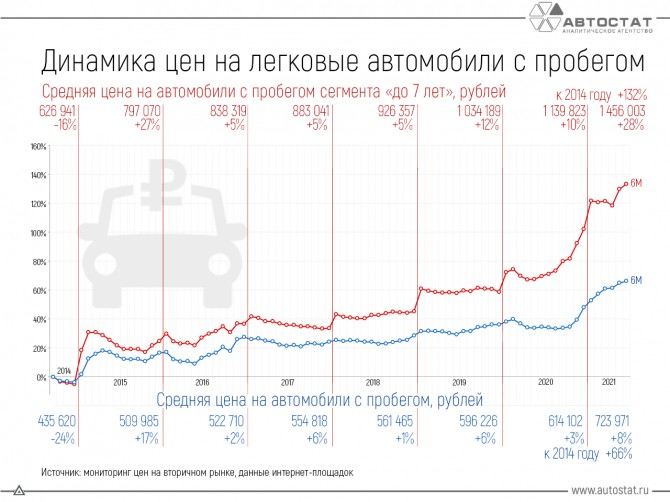

In [148]:
image_url_1='https://www.autostat.ru/application/includes/blocks/big_photo/images/cache/000/094/996/aba1c0d9-670-0.jpg'
Image(image_url_1,width=700, height='auto')

### С пробегом до 7 лет

In [149]:
# Данные авто за 2014 с пробегом до 7 лет и датой выпуска модели после 2014 (48%)
train.loc[(train.productionDate > 2014) & (train.mileage != 0.0) & (
    train.pars_date == 2014), 'price'] = train['price'] + (train['price'] * 0.48)

# Данные авто за 2015 с пробегом до 7 лет и датой выпуска модели после 2014 (37%)
train.loc[(train.productionDate > 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2015), 'price'] = train['price'] + (train['price'] * 0.37)

# Данные авто за 2016 с пробегом до 7 лет и датой выпуска модели после 2014 (32%)
train.loc[(train.productionDate > 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2016), 'price'] = train['price'] + (train['price'] * 0.32)

# Данные авто за 2017 с пробегом до 7 лет и датой выпуска модели после 2014 (27%)
train.loc[(train.productionDate > 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2017), 'price'] = train['price'] + (train['price'] * 0.27)

# Данные авто за 2018 с пробегом до 7 лет и датой выпуска модели после 2014 (22%)
train.loc[(train.productionDate > 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2018), 'price'] = train['price'] + (train['price'] * 0.22)

# Данные авто за 2019 с пробегом до 7 лет и датой выпуска модели после 2014 (10%)
train.loc[(train.productionDate > 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2019), 'price'] = train['price'] + (train['price'] * 0.10)

In [150]:
# Данные авто за 2021 с пробегом до 7 лет и датой выпуска модели после 2014 (-28%)
train_parsed.loc[(train_parsed.productionDate > 2014) & (
    train_parsed.mileage != 0.0), 'price'] = train_parsed['price'] - (train_parsed['price'] * 0.28)

### С пробегом после 7 лет

In [151]:
# Данные авто за 2014 с пробегом и датой выпуска модели до 2014 (11%)
train.loc[(train.productionDate < 2014) & (train.mileage != 0.0) & (
    train.pars_date == 2014), 'price'] = train['price'] + (train['price'] * 0.11)

# Данные авто за 2015 с пробегом и датой выпуска модели до 2014 (18%)
train.loc[(train.productionDate < 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2015), 'price'] = train['price'] + (train['price'] * 0.18)

# Данные авто за 2016 с пробегом и датой выпуска модели до 2014 (16%)
train.loc[(train.productionDate < 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2016), 'price'] = train['price'] + (train['price'] * 0.16)

# Данные авто за 2017 с пробегом и датой выпуска модели до 2014 (10%)
train.loc[(train.productionDate < 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2017), 'price'] = train['price'] + (train['price'] * 0.10)

# Данные авто за 2018 с пробегом и датой выпуска модели до 2014 (9%)
train.loc[(train.productionDate < 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2018), 'price'] = train['price'] + (train['price'] * 0.09)

# Данные авто за 2019 с пробегом и датой выпуска модели до 2014 (3%)
train.loc[(train.productionDate < 2014) & (
    train.mileage != 0.0) & (train.pars_date == 2019), 'price'] = train['price'] + (train['price'] * 0.03)

In [152]:
# Данные авто за 2021 с пробегом после 7 лет и датой выпуска модели до 2014 (-8%)
train_parsed.loc[(train_parsed.productionDate < 2014) & (
    train_parsed.mileage != 0.0), 'price'] = train_parsed['price'] - (train_parsed['price'] * 0.8)

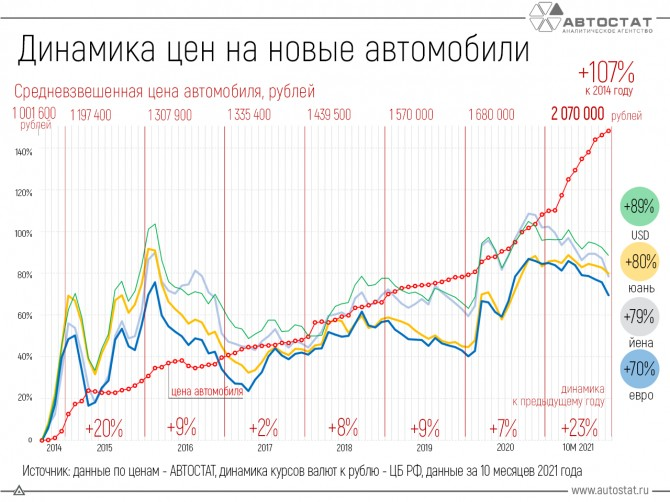

In [153]:
image_url_2='https://www.autostat.ru/application/includes/blocks/big_photo/images/cache/000/098/537/e44a2300-670-0.jpg'
Image(image_url_2,width=700, height='auto')

### Без пробега дата выупска после 2014

In [154]:
# Данные авто за 2018 без пробега и датой выпуска модели после 2014 (16%)
train.loc[(train.productionDate > 2014) & (
    train.mileage == 0.0) & (train.pars_date == 2018), 'price'] = train['price'] + (train['price'] * 0.16)

# Данные авто за 2019 без пробега и датой выпуска модели после 2014 (7%)
train.loc[(train.productionDate > 2014) & (
    train.mileage == 0.0) & (train.pars_date == 2019), 'price'] = train['price'] + (train['price'] * 0.07)

In [155]:
# Данные авто за 2021 без пробега и датой выпуска модели после 2014 (-23%)
train_parsed.loc[(train_parsed.productionDate > 2014) & (
    train_parsed.mileage == 0.0), 'price'] = train_parsed['price'] - (train_parsed['price'] * 0.23)

## Проврека столбцов

In [156]:
train.isna().sum()

bodyType               0
brand                  0
color                  0
fuelType               0
modelDate              0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
engineDisplacement     0
enginePower            0
mileage                0
driving_gear           0
Руль                   0
Состояние              0
Владельцы              0
ПТС                    0
Таможня                0
price                  0
pars_date              0
model_name             0
vendor                 0
dtype: int64

In [157]:
train_parsed.isna().sum()

bodyType                   0
brand                      0
car_url                    0
color                      0
engineDisplacement         0
enginePower                0
equipment_dict             0
fuelType                   0
image                      8
mileage                    0
modelDate                  0
numberOfDoors              0
pars_date                  0
priceCurrency              0
productionDate             0
sell_id                    0
super_gen                  0
vehicleTransmission        0
vendor                     0
Владельцы                  0
ПТС                        0
driving_gear               0
Руль                       0
Состояние                  0
Таможня                    0
views                  22084
date_added             21152
region                 21152
price                      0
model_name              7856
dtype: int64

In [158]:
test.isna().sum()

bodyType                  0
brand                     0
car_url                   0
color                     0
engineDisplacement        0
enginePower               0
equipment_dict         9996
fuelType                  0
image                     0
mileage                   0
modelDate                 0
model_info                0
model_name                0
numberOfDoors             0
pars_date                 0
priceCurrency             0
productionDate            0
sell_id                   0
super_gen                 0
vehicleTransmission       0
vendor                    0
Владельцы                 0
ПТС                       0
driving_gear              0
Руль                      0
Состояние                 0
Таможня                   0
price                     0
dtype: int64

In [159]:
# Возможность скинуть пустые значения, но качество метрики ухудшается, т.к. что оставляем
#train_parsed.dropna(subset = ['model_name'], axis= 0, inplace = True)

In [160]:
train_parsed.drop(columns = ['views','date_added','region','image'], axis = 1, inplace = True)
test.drop(['equipment_dict'], axis = 1, inplace = True)

In [161]:
train_parsed.model_name.isna().value_counts()

False    101908
True       7856
Name: model_name, dtype: int64

## Сравнение столбцов

In [162]:
check_df(train_parsed, test)

Columns in df1, but not in df2:  ['equipment_dict']
df1 : df2

sell_id float64  |  sell_id int64


In [163]:
# Меняем тип данных sell_id в train_parsed. Избавляемся от повторяющихся значений в датасете train_parsed.
train_parsed['sell_id'] = train_parsed.sell_id.astype(np.int64)
train_parsed = (train_parsed[~train_parsed.sell_id.isin(test.sell_id)])

# Удаляем оба sell_id
train_parsed.drop(['sell_id'], axis = 1, inplace = True)
test.drop(['sell_id'], axis = 1, inplace = True)

In [164]:
train_parsed.drop(['equipment_dict', 'car_url', 
                   'priceCurrency', 'super_gen'], axis = 1, inplace = True)
test.drop(['car_url', 'image', 'model_info','priceCurrency', 'super_gen'], axis = 1, inplace = True)

In [165]:
for df in [train, train_parsed, test]:
    df.rename(columns = {'bodyType' : 'body_type', 'engineDisplacement' : 'engine_displacement',
                           'enginePower' : 'engine_power', 'numberOfDoors' : 'doors',
                           'productionDate' : 'production_date', 'vehicleTransmission' : 'transmission',
                           'Владельцы' : 'owners', 'ПТС' : 'vehicle_licence',
                           'Руль' : 'steering_wheel', 'Состояние' : 'condition',
                           'Таможня' : 'customs', 'modelDate' : 'model_date'}, inplace = True)

## Объединение датасетов

In [166]:
df = pd.concat([train, train_parsed], ignore_index = True)

## Классификация перемен

In [167]:
#Разделяем по классификации переменные

#бинарные переменные 
bin_cols = ['condition', 'customs', 'steering_wheel', 'vehicle_licence', 'vendor']

#категориальные переменные
cat_cols = ['body_type', 'brand', 'color', 'driving_gear', 'fuelType', 'model_name',
           'transmission']

#числовые переменные
num_cols = ['doors', 'engine_displacement', 'engine_power', 'mileage', 'model_date',
               'owners', 'pars_date', 'production_date']

<AxesSubplot:>

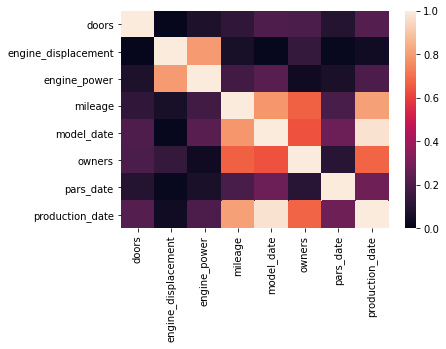

In [168]:
#Корреляция Пирсона
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [169]:
# Судя по корреляции лучше избавиться от model_date, т.к. выпуск важнее.
df.drop('model_date', axis = 1, inplace = True)
test.drop('model_date', axis = 1, inplace = True)

#числовые переменные
num_cols = ['doors', 'engine_displacement', 'engine_power', 'mileage', 
            'owners', 'pars_date', 'production_date']

<AxesSubplot:>

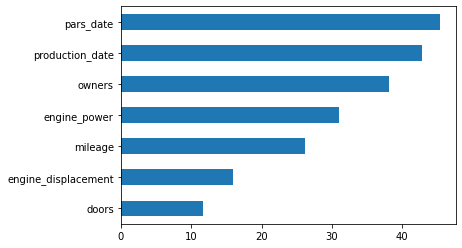

In [170]:
#Используем функцию f_classif для анализа значимости признака для нашей линейной модели
imp_num = pd.Series(f_classif(df[num_cols], df['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [171]:
# pars_date берет на себя слишком много внимания. Так что, удаляем.
df.drop('pars_date', axis = 1, inplace = True)
test.drop('pars_date', axis = 1, inplace = True)

In [172]:
#числовые переменные
num_cols = ['doors', 'engine_displacement', 'engine_power', 'mileage', 
            'owners', 'production_date']

## Визуализация

In [173]:
df['train'] = 1
test['train'] = 0

In [174]:
df = pd.concat([df, test], ignore_index = True)

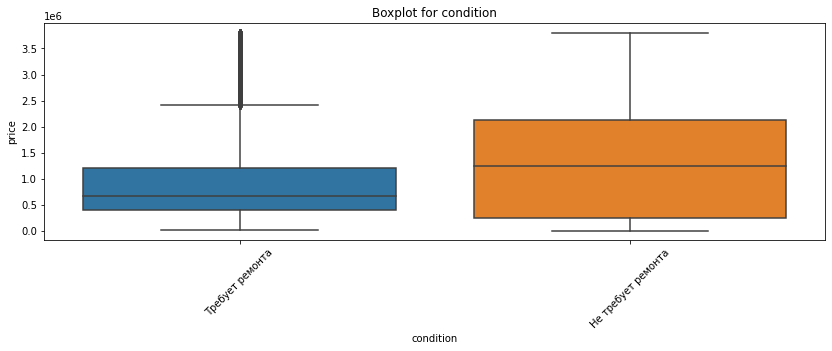

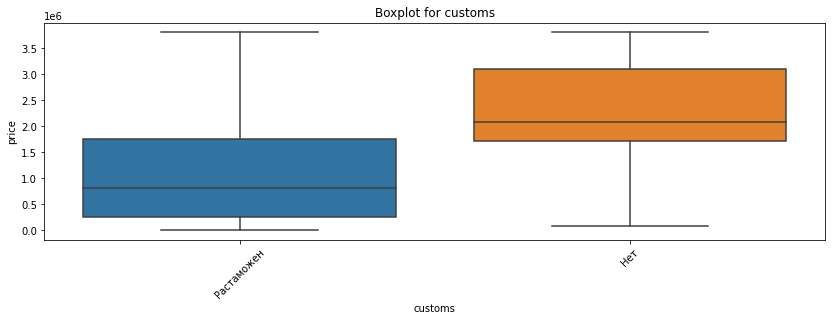

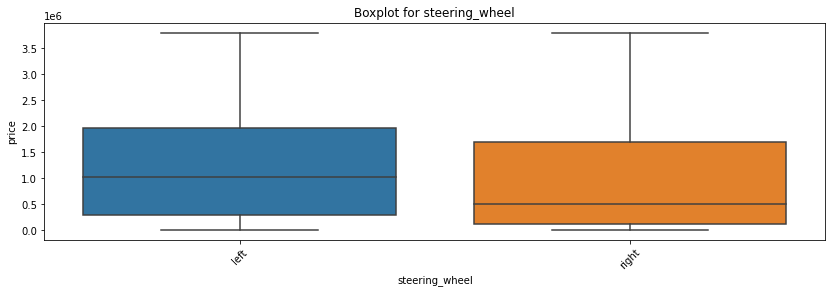

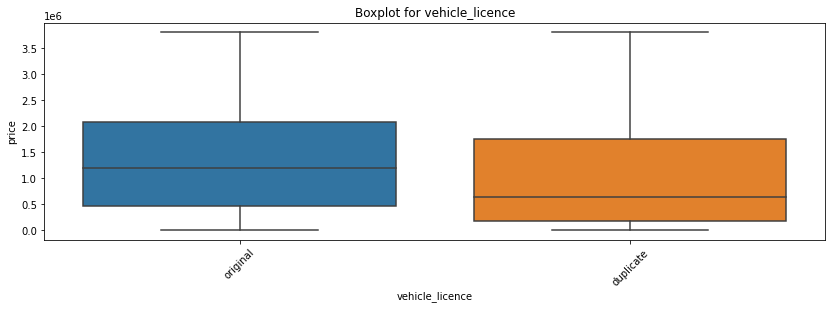

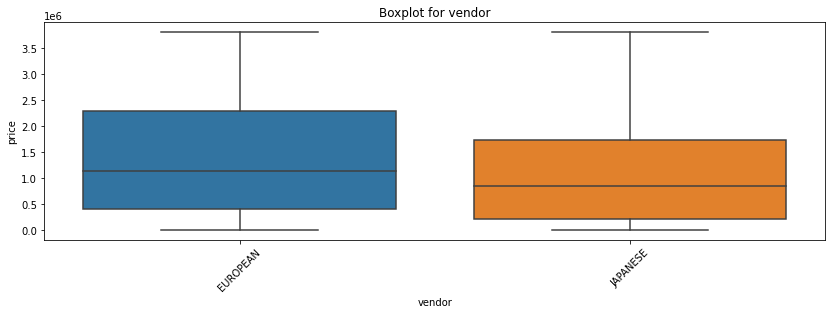

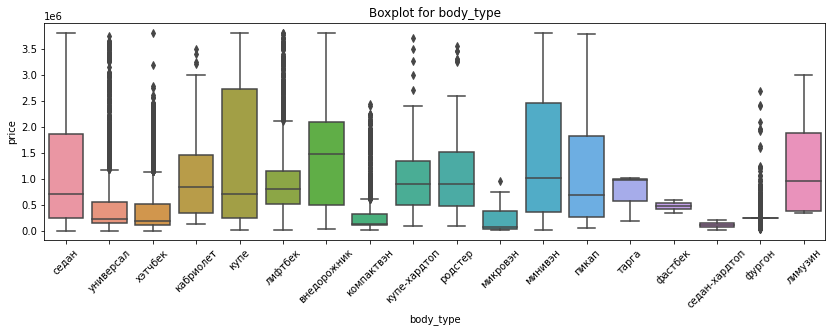

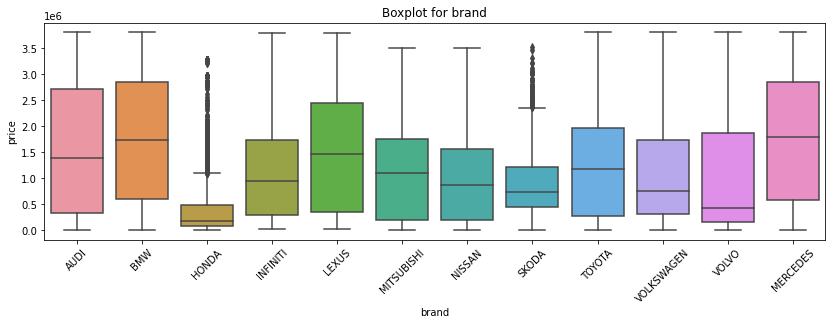

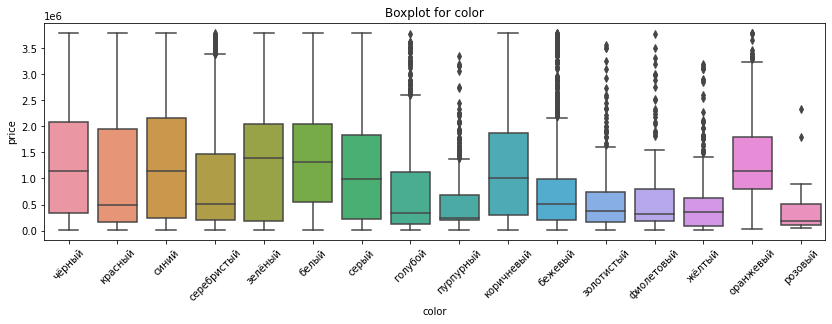

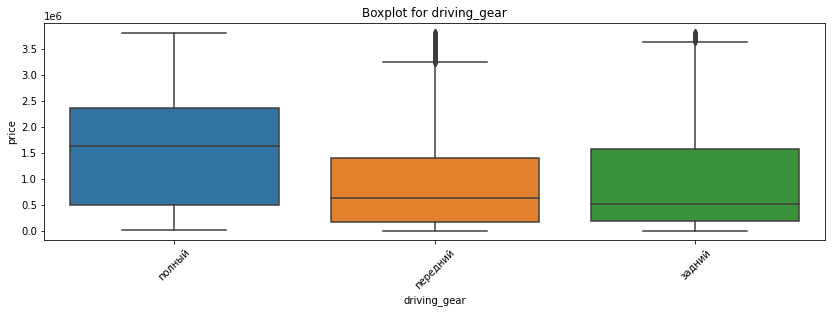

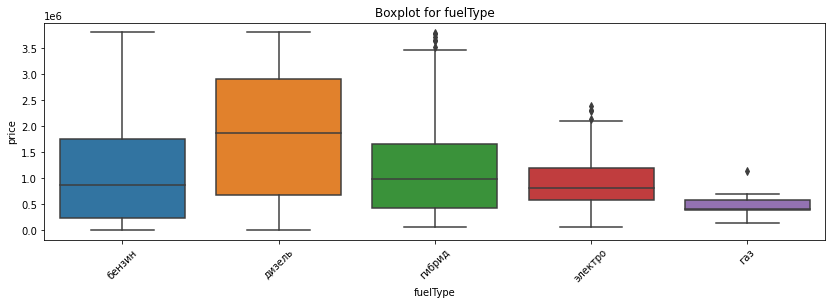

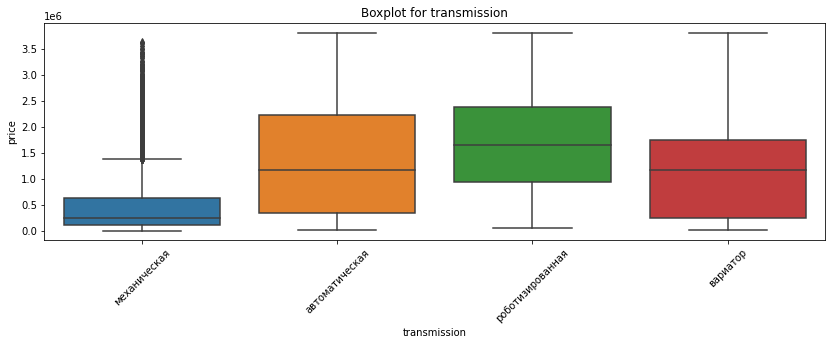

In [175]:
for col in bin_cols + cat_cols:
    if col not in ['model_name', 'name']:
        show_boxplot(data=df[
            (df.price <= df.price.quantile(0.9)) & (df.train == 1)], column=col, target_column='price')

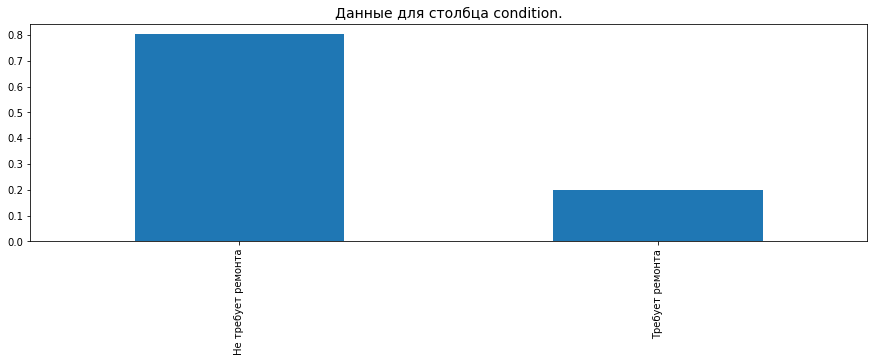

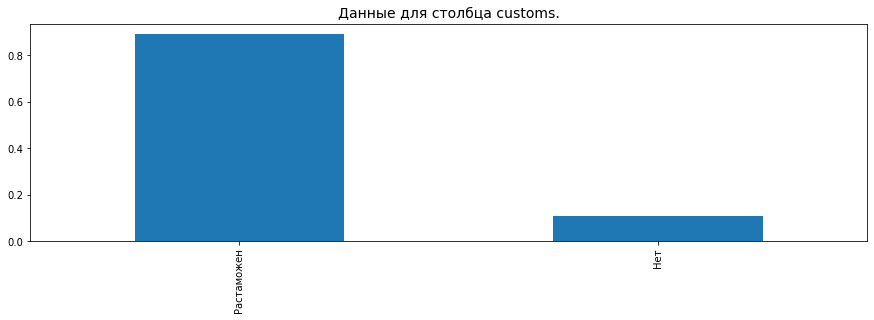

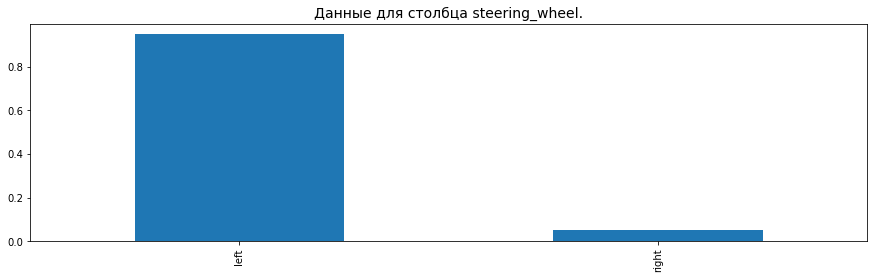

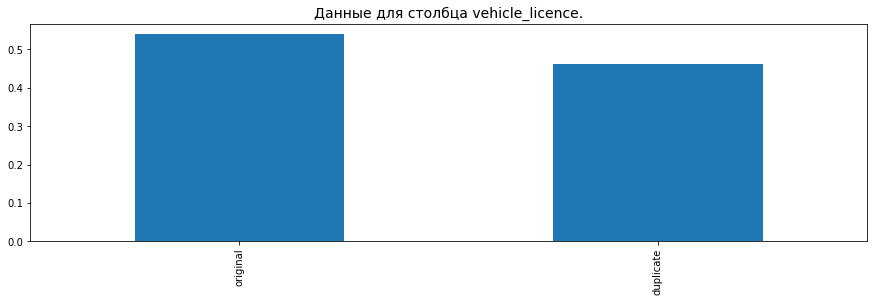

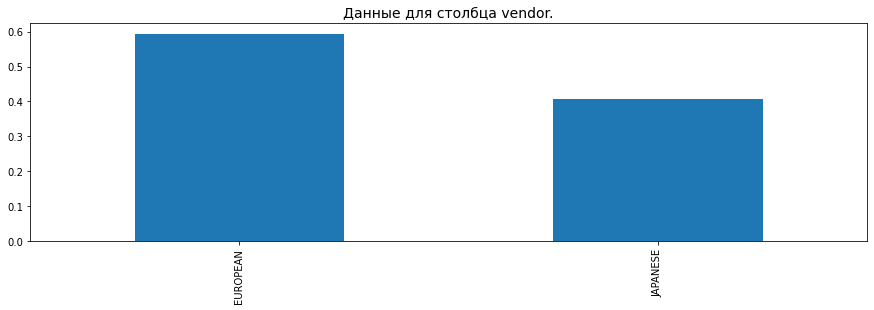

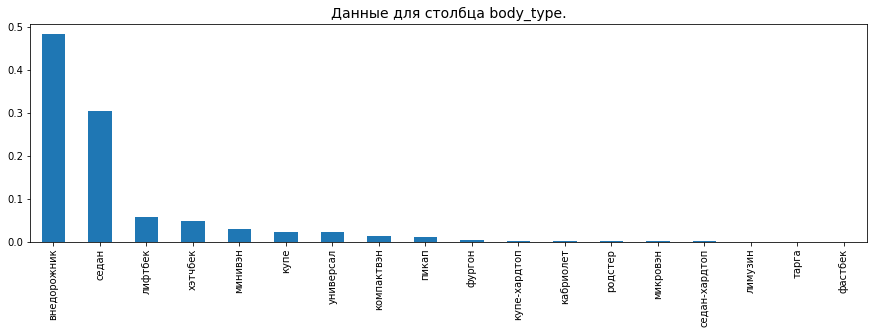

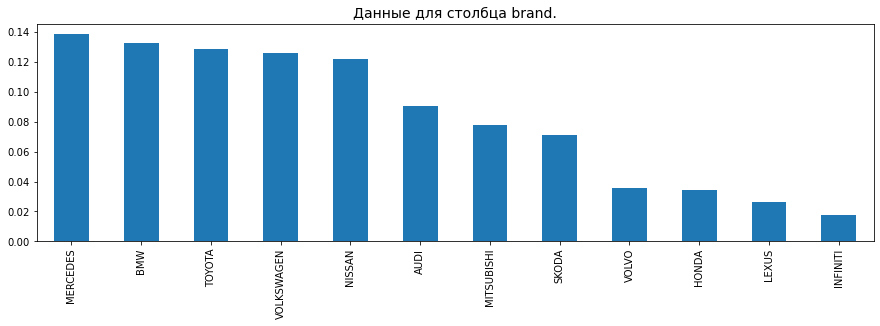

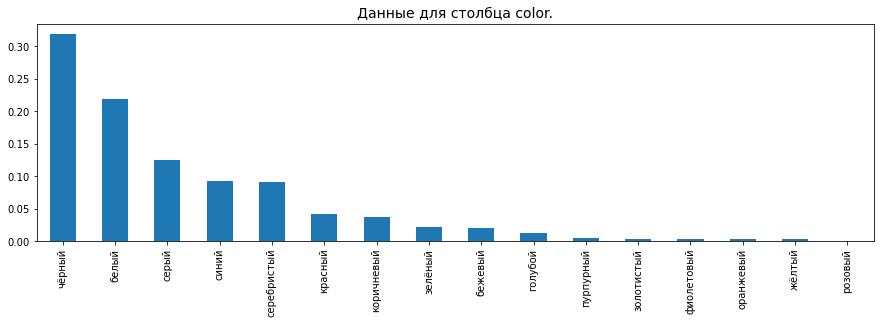

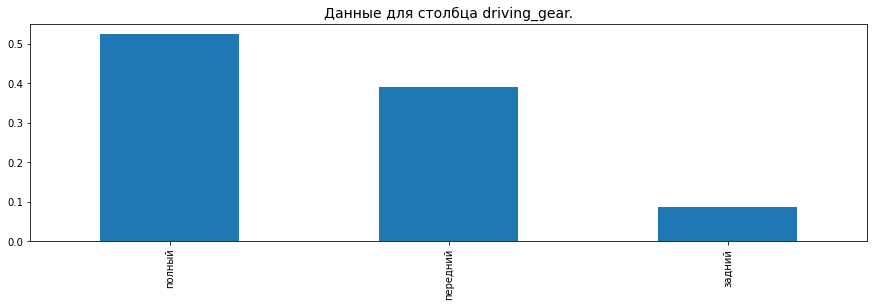

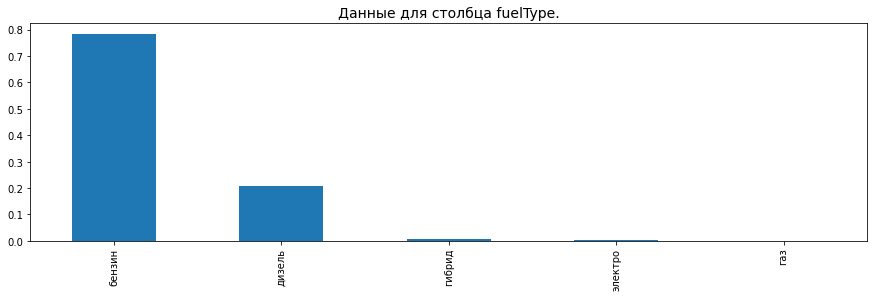

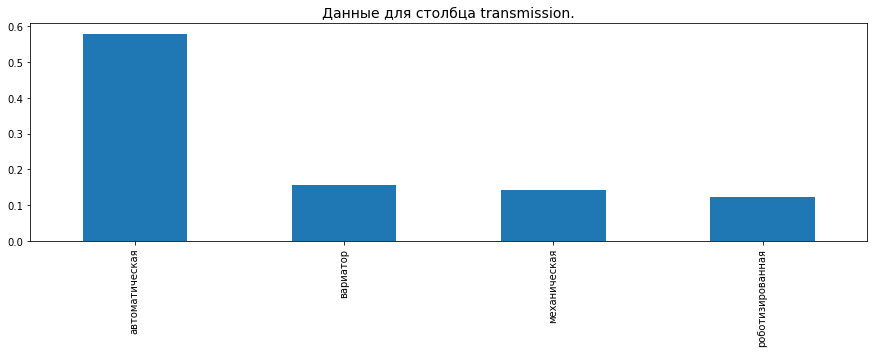

In [176]:
for col in bin_cols + cat_cols:
    if col not in ['model_name', 'name']: # these columns have too many categories, the plots don't show any useful information for them. Create new features!
        fig, ax = plt.subplots(figsize=(15, 4))
        ax.set_title(f'Данные для столбца {col}.', fontdict={'fontsize': 14})
        df[col].value_counts(normalize=True).plot(kind='bar', ax=ax)

# Преобразование данных перед машинным обучением

In [177]:
# Меняем значения в переменных
df['vehicle_licence'] = df['vehicle_licence'].apply(lambda x: 1 if x == 'original' else 0)
df['steering_wheel'] = df['steering_wheel'].apply(lambda x: 1 if x == 'left' else 0)
df['vendor'] = df.vendor.apply(lambda x: 1 if x == 'EUROPEAN' else 0)
df['customs'] = df['customs'].apply(lambda x: 1 if x == 'Растаможен' else 0)
df['condition'] = df['condition'].apply(lambda x: 0 if x == 'Не требует ремонта' else 1).astype(np.int64)

In [178]:
test_original = df.query('train == 0').drop(['train', 'price'], axis = 1)

In [179]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,body_type,brand,color,fuelType,doors,production_date,transmission,engine_displacement,engine_power,mileage,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,vendor,train
0,седан,AUDI,чёрный,бензин,4.0,1991,механическая,2.8,174.0,350000,полный,1,1,3.0,1,1,206000.0,100,1,1
1,седан,AUDI,красный,бензин,4.0,1986,механическая,1.8,90.0,173424,передний,1,1,3.0,1,1,60000.0,100,1,1
2,универсал,AUDI,синий,бензин,5.0,1989,механическая,2.3,136.0,230000,полный,1,1,3.0,1,1,99000.0,100,1,1
3,седан,AUDI,серебристый,бензин,4.0,1989,механическая,1.8,90.0,240000,передний,1,1,3.0,1,1,65000.0,100,1,1
4,седан,AUDI,чёрный,бензин,4.0,1991,механическая,2.0,101.0,300000,передний,1,1,3.0,0,1,100000.0,100,1,1


In [180]:
# Для категориальных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,body_type,brand,color,fuelType,doors,production_date,transmission,engine_displacement,engine_power,mileage,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,vendor,train
0,11,0,15,0,4.0,1991,2,2.8,174.0,350000,2,1,1,3.0,1,1,206000.0,1,1,1
1,11,0,7,0,4.0,1986,2,1.8,90.0,173424,1,1,1,3.0,1,1,60000.0,1,1,1
2,14,0,13,0,5.0,1989,2,2.3,136.0,230000,2,1,1,3.0,1,1,99000.0,1,1,1
3,11,0,11,0,4.0,1989,2,1.8,90.0,240000,1,1,1,3.0,1,1,65000.0,1,1,1
4,11,0,15,0,4.0,1991,2,2.0,101.0,300000,1,1,1,3.0,0,1,100000.0,1,1,1


### Подготовка выборок

In [181]:
#Разделяем наши преобразованные данные на два датасета (тренировочный и тестовый)
train_data = df.query('train == 1').drop(['train'], axis=1)
test_data = df.query('train == 0').drop(['train', 'price'], axis=1)

In [182]:
#Создаем тренировочную и валидационную выборки
train, validation = train_test_split(train_data, test_size=0.3, random_state=RANDOM_SEED)

In [183]:
x_train = train.drop('price', axis = 1)
y_train = train['price'].astype(np.int32)

x_valid = validation.drop('price', axis = 1)
y_valid = validation['price'].astype(np.int32)

x_test = test_data.copy()

In [184]:
# Стандартизируем данные, определив в другую переменную
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)

x_test_scaler = scaler.transform(x_test)

# Модель 1: Naive ML model

In [185]:
tmp_train = x_train.copy()
tmp_train['price'] = y_train
# Находим median по экземплярам всех переменных num_cols (другие показывают куда более хужший результат)

#оцениваем точность каждой переменной
for col in num_cols:
    y_pred = x_valid[col].map(tmp_train.groupby(col)['price'].median())
    print(f"The MAPE of the Naive model for {col}: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

The MAPE of the Naive model for doors: 270.55%.
The MAPE of the Naive model for engine_displacement: 213.87%.
The MAPE of the Naive model for engine_power: 156.13%.
The MAPE of the Naive model for mileage: 66.63%.
The MAPE of the Naive model for owners: 147.79%.
The MAPE of the Naive model for production_date: 62.91%.


#### Cудя по MAPE метрики - наивная модель МО нам не подходит.

# Модель 2: CatBoost

In [186]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(x_train, y_train,
         eval_set=(x_valid, y_valid),
         verbose_eval=0,
         use_best_model=True)

y_pred = model.predict(x_valid)
# оцениваем точность
print(f"The MAPE of the CatBoost model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

The MAPE of the CatBoost model: 10.84%.


#### CatBoost показал куда более лучший результат. 

# Модель 3: RandomForest

In [187]:
# Без StandardScaler
myModel = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
myModel.fit(x_train, y_train)
y_pred = myModel.predict(x_valid)

print(f"The MAPE of the RandomForest model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s


The MAPE of the RandomForest model: 8.05%.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


In [188]:
# C StandardScaler
myModel = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
myModel.fit(x_train_scaler, y_train)
y_pred = myModel.predict(x_valid_scaler)

print(f"The MAPE of the RandomForest model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s


The MAPE of the RandomForest model: 8.02%.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


#### На данный момент лучший показатель.

# Модель 4: ExtraTrees

In [189]:
# with log-transformation of the target variable
myModel = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

myModel.fit(x_train_scaler, y_train)
y_pred = myModel.predict(x_valid_scaler)

print(f"The MAPE of the ExtraTrees model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s


The MAPE of the ExtraTrees model: 8.55%.


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


#### Хороший результат, но результат уступает случайному лесу.

# Модель 5: Stacking

In [190]:
# Создаем словарь с моделями, что будем использовать в качестве стекинга
estimators = [
    ('ran', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('ext',ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('xgb',XGBRegressor(objective='reg:squarederror', 
                         colsample_bytree=0.5, 
                         learning_rate=0.05, 
                         max_depth=12, 
                         alpha=1, 
                         n_jobs=-1, 
                         n_estimators=1000, 
                         random_state=RANDOM_SEED))]

In [191]:
# Добавляем в качестве конечного алгоритма линейную регрессию
stackingModel = StackingRegressor(
     estimators=estimators,
     final_estimator=LinearRegression())

In [192]:
stackingModel.fit(x_train_scaler, y_train)
y_pred = stackingModel.predict(x_valid_scaler)

print(f"The MAPE of the Stacking model: {(np.mean(np.abs((y_pred-y_valid)/y_valid)) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: D

The MAPE of the Stacking model: 8.77%.


#### Хороший результат, но и этот результат уступает случайному лесу.

# Используем модель 3 в качестве предсказания

In [193]:
myModel = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
myModel.fit(x_train_scaler, y_train)

y_pred = myModel.predict(x_test_scaler)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [194]:
test_original['price'] = y_pred

In [195]:
#test_original
sample_submission = sample.copy()
sample_submission['price'] = y_pred

In [196]:
sample_submission.to_csv(f'sample_submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.467929e+05
1,1100549428,9.262748e+05
2,1100658222,9.718269e+05
3,1100937408,7.285746e+05
4,1101037972,1.944574e+05
5,1100912634,1.975276e+05
6,1101228730,1.796341e+05
7,1100165896,9.790036e+04
8,1100768262,1.720807e+06
9,1101218501,1.171997e+06
